### 1. Preparación del dataset

#### 1.1. Lectura del conjunto de datos

In [1]:
from scipy.io import loadmat
data=loadmat("PaviaUniversity_Image")['paviaU']
labels=loadmat("Pavia_University_ground_truth")['paviaU_gt']
H,W,C=data.shape

#### 1.2. Reducción de la dimensionalidad

In [2]:
from sklearn.decomposition import PCA
n_components=22 # Nuestro análisis abarca 20 bandas
data=data.reshape(H*W,C)
pca=PCA(n_components=n_components,whiten=True)
data=pca.fit_transform(data)

#### 1.3. Normalización de los datos

In [3]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
standar_scaler=StandardScaler()
data=standar_scaler.fit_transform(data)
data=data.reshape(H,W,n_components);

#### 1.4. Aproximación parche a pixel

In [4]:
import numpy as np

def padWithZeros(X, margin=2):
    newX=np.zeros((X.shape[0]+2*margin,X.shape[1]+2*margin, X.shape[2]))
    x_offset=margin
    y_offset=margin 
    newX[x_offset:X.shape[0]+x_offset, y_offset:X.shape[1]+y_offset,:]=X
    return newX

def createImageCubes(X,y,windowSize=9, removeZeroLabels=True): #Regresar a 5
    margin=int((windowSize-1)/2)
    zeroPaddedX=padWithZeros(X,margin=margin)
    patchesData=np.zeros((X.shape[0]*X.shape[1],windowSize,windowSize,X.shape[2]))
    patchesLabels=np.zeros((X.shape[0]*X.shape[1]))
    patchIndex=0
    for r in range(margin,zeroPaddedX.shape[0]-margin):
        for c in range(margin,zeroPaddedX.shape[1]-margin):
            patch=zeroPaddedX[r-margin:r+margin+1,c-margin:c+margin+1]
            patchesData[patchIndex,:,:,:]=patch 
            patchesLabels[patchIndex]=y[r-margin,c-margin]
            patchIndex=patchIndex+1
    if removeZeroLabels:
        patchesData=patchesData[patchesLabels>0,:,:,:]
        patchesLabels=patchesLabels[patchesLabels>0]
        patchesLabels -=1
    from keras.utils import np_utils
    patchesLabels=np_utils.to_categorical(patchesLabels)
    return patchesData,patchesLabels 

#### 1.5. Acondicionar el conjunto de datos

In [5]:
x_train,y_train=createImageCubes(data,labels,removeZeroLabels=True)

In [6]:
n_clases=y_train.shape[1]

#### 1.6. Partir Dataset

In [7]:
# TEST 40%, TRAIN 48%, VALIDATION 12%
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x_train,y_train,test_size=0.4,shuffle=True,random_state=0,stratify=y_train) #0.4 100% 0.9--0.79
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=0.2,shuffle=True,random_state=0,stratify=y_train)

### 2. Red Neuronal Convolucional

In [8]:
from tensorflow.keras.layers import Input,Conv2D,Dropout,BatchNormalization,Flatten,Dense,LayerNormalization
from tensorflow.keras.models import Model 
from tensorflow.keras.callbacks import EarlyStopping

In [9]:
shapes=(9,9,n_components)
inputs=Input(shapes)
x=Conv2D(64,(3,3),activation="relu",padding="same")(inputs) # 64 por 60
x=Dropout(0.2)(x)
x=BatchNormalization()(x)
x=Conv2D(32,(3,3),activation="relu")(x)
x=Dropout(0.2)(x)
x=BatchNormalization()(x)
x=Conv2D(32,(3,3),activation="relu")(x)
x=Dropout(0.2)(x)
x=BatchNormalization()(x)
x=Flatten()(x)
x=Dense(n_clases,activation="relu")(x) #256 en vez de 243
x=Dropout(0.2)(x)
x=Dense(n_clases,activation="softmax")(x)

model=Model(inputs=inputs,outputs=x)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [10]:
callback=EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True)

#### 2.1. Entrenamiento

In [11]:
history=model.fit(x_train,y_train,epochs=100,batch_size=128,validation_data=(x_val,y_val),callbacks=[callback])

Epoch 1/100
161/161 [==============================] - 7s 21ms/step - loss: 1.0167 - accuracy: 0.6792 - val_loss: 0.4468 - val_accuracy: 0.9558
Epoch 2/100
161/161 [==============================] - 2s 15ms/step - loss: 0.4361 - accuracy: 0.9168 - val_loss: 0.2538 - val_accuracy: 0.9895
Epoch 3/100
161/161 [==============================] - 2s 15ms/step - loss: 0.3454 - accuracy: 0.9394 - val_loss: 0.2155 - val_accuracy: 0.9965
Epoch 4/100
161/161 [==============================] - 2s 15ms/step - loss: 0.2797 - accuracy: 0.9416 - val_loss: 0.0337 - val_accuracy: 0.9977
Epoch 5/100
161/161 [==============================] - 2s 15ms/step - loss: 0.1453 - accuracy: 0.9502 - val_loss: 0.0137 - val_accuracy: 0.9957
Epoch 6/100
161/161 [==============================] - 3s 16ms/step - loss: 0.1266 - accuracy: 0.9569 - val_loss: 0.0049 - val_accuracy: 0.9992
Epoch 7/100
161/161 [==============================] - 2s 15ms/step - loss: 0.1048 - accuracy: 0.9632 - val_loss: 0.0109 - val_accuracy:

In [12]:
dic_curves_IP={}
dic_curves_IP["val_accuracy"]=history.history["val_accuracy"]
dic_curves_IP["accuracy"]=history.history["accuracy"]
dic_curves_IP["loss"]=history.history["loss"]
dic_curves_IP["val_loss"]=history.history["val_loss"]

import pickle 

with open("accu_loss_CNN2D.pkl","wb") as f:
    pickle.dump(dic_curves_IP,f)

#### 3. Evaluación

#### 3.1. Evaluacion Test

In [13]:
evaluacion_test=model.evaluate(x_test,y_test)

535/535 [==============================] - 3s 5ms/step - loss: 9.5159e-04 - accuracy: 0.9999


#### 3.2. Classification Report

In [14]:
y_pred=model.predict(x_test)
y_pred=np.argmax(y_pred,axis=1)
from sklearn.metrics import classification_report
clases_dataset_PU=["ASPHALT","MEADOWS","GRAVEL","TREES","PAINTED_METAL_SHEETS","BARE_SOIL","BITUMEN","SELF_BLOCKING_BRICKS","SHADOWS"]
target_names=clases_dataset_PU
classification=classification_report(np.argmax(y_test,axis=1),y_pred,target_names=target_names)
print(classification)

535/535 [==============================] - 2s 3ms/step
                      precision    recall  f1-score   support

             ASPHALT       1.00      1.00      1.00      2652
             MEADOWS       1.00      1.00      1.00      7460
              GRAVEL       1.00      1.00      1.00       839
               TREES       1.00      1.00      1.00      1226
PAINTED_METAL_SHEETS       1.00      1.00      1.00       538
           BARE_SOIL       1.00      1.00      1.00      2012
             BITUMEN       1.00      1.00      1.00       532
SELF_BLOCKING_BRICKS       1.00      1.00      1.00      1473
             SHADOWS       1.00      1.00      1.00       379

            accuracy                           1.00     17111
           macro avg       1.00      1.00      1.00     17111
        weighted avg       1.00      1.00      1.00     17111



#### 3.3. Cohen Kappa

In [15]:
from sklearn.metrics import cohen_kappa_score
a=y_pred
b=np.argmax(y_test,axis=1)
cks=cohen_kappa_score(a,b)
cks

np.save("cohen_kappa_score_cnn2d",cks)

In [16]:
import numpy as np 
np.load("cohen_kappa_score_cnn2d.npy")

array(0.99984512)

In [17]:
import pandas as pd 

pd_reporte_clasificacion=pd.DataFrame(classification_report(np.argmax(y_test,axis=1),y_pred,target_names=target_names,output_dict=True)).transpose()
pd_reporte_clasificacion.to_csv("reporte_clasificacion_cnn2d.csv")

In [18]:
y_pred,_=createImageCubes(data,labels,removeZeroLabels=False)
y_pred=model.predict(y_pred,batch_size=128)
y_pred=np.argmax(y_pred,axis=1)
y_pred=y_pred.reshape(H,W)

1621/1621 [==============================] - 6s 3ms/step


In [19]:
pred_gt=y_pred+np.ones_like(y_pred)

In [20]:
mask=np.array([labels])>0 # Generamos máscaras.
mask=mask.astype("uint8")
y_pred=mask*pred_gt
y_pred=y_pred.reshape(data.shape[0],data.shape[1])

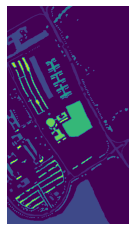

In [21]:
import matplotlib.pyplot as plt 
plt.imshow(y_pred)
plt.axis("off");

In [22]:
np.save("y_pred_cnn2d",y_pred)

(-0.5, 339.5, 609.5, -0.5)

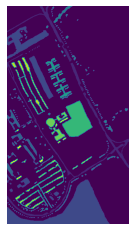

In [23]:
plt.imshow(labels)
plt.axis("off")

In [24]:
from sklearn.metrics import accuracy_score
a=y_pred.reshape(H*W)
b=labels.reshape(H*W)
cohen_kappa_score(a,b)

0.9999597667480594

In [25]:
accuracy_score(a,b)

0.9999855351976856

In [26]:
from keras.metrics import MeanIoU 
n_classes=10
IOU_mean=MeanIoU(num_classes=n_classes)
IOU_mean.update_state(y_pred,labels)
print("Mean IoU",IOU_mean.result().numpy())
np.save("IoU_cnn2d",IOU_mean.result().numpy()) #IOU 0.9999

Mean IoU 0.99979746


In [27]:
# IoU por clase.
# IoU por clase.
from keras.metrics import IoU
clases=["UNLABELED","ASPHALT","MEADOWS","GRAVEL","TREES","PAINTED_METAL_SHEETS","BARE_SOIL","BITUMEN","SELF_BLOCKING_BRICKS","SHADOWS"]
IoU_class_report=[]
for i in range(10):
    IoU_class=IoU(num_classes=10,target_class_ids=[i])
    IoU_class.update_state(y_pred,labels)
    IoU_class_report.append(IoU_class.result().numpy())
    print(clases[i],":", IoU_class.result().numpy())

UNLABELED : 1.0
ASPHALT : 0.9998492
MEADOWS : 1.0
GRAVEL : 1.0
TREES : 0.99934745
PAINTED_METAL_SHEETS : 1.0
BARE_SOIL : 0.9998012
BITUMEN : 0.99924815
SELF_BLOCKING_BRICKS : 0.9997284
SHADOWS : 1.0


In [28]:
np.save("reporte_IoU_cnn2d",IoU_class_report)

In [29]:
from keras.metrics import IoU
clases=["UNLABELED","ASPHALT","MEADOWS","GRAVEL","TREES","PAINTED_METAL_SHEETS","BARE_SOIL","BITUMEN","SELF_BLOCKING_BRICKS","SHADOWS"]
IoU_class_report=[]
for i in range(n_clases+1):
    IoU_class=IoU(num_classes=n_clases+1,target_class_ids=[i])
    IoU_class.update_state(y_pred,labels)
    IoU_class_report.append(IoU_class.result().numpy())
    print(IoU_class.result().numpy())

1.0
0.9998492
1.0
1.0
0.99934745
1.0
0.9998012
0.99924815
0.9997284
1.0
